In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import os
import glob
from tqdm.notebook import tqdm
import plotly
import plotly.express as ex
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline
# Preprocessing the data
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
# from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import keras
from tensorflow.keras.optimizers import Adam, SGD
from keras.models import Model,load_model
from tensorflow.keras.layers import Dense, Dropout,Conv2D,Flatten,MaxPooling2D
from keras import backend as K
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/new/archive.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
train_data = glob.glob('/tmp/chest_xray/train/**/*.jpeg')
test_data = glob.glob('/tmp/chest_xray/test/**/*.jpeg')
val_data = glob.glob('/tmp/chest_xray/val/**/*.jpeg')

print(f"Training Set has: {len(train_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print(f"Validation Set has: {len(val_data)} images")

Training Set has: 5216 images
Testing Set has: 624 images
Validation Set has: 16 images


In [ ]:
plot={"train":[pneumonia_train,normal_train],"test":[pneumonia_test,normal_test],"val":[pneumonia_val,normal_val]}

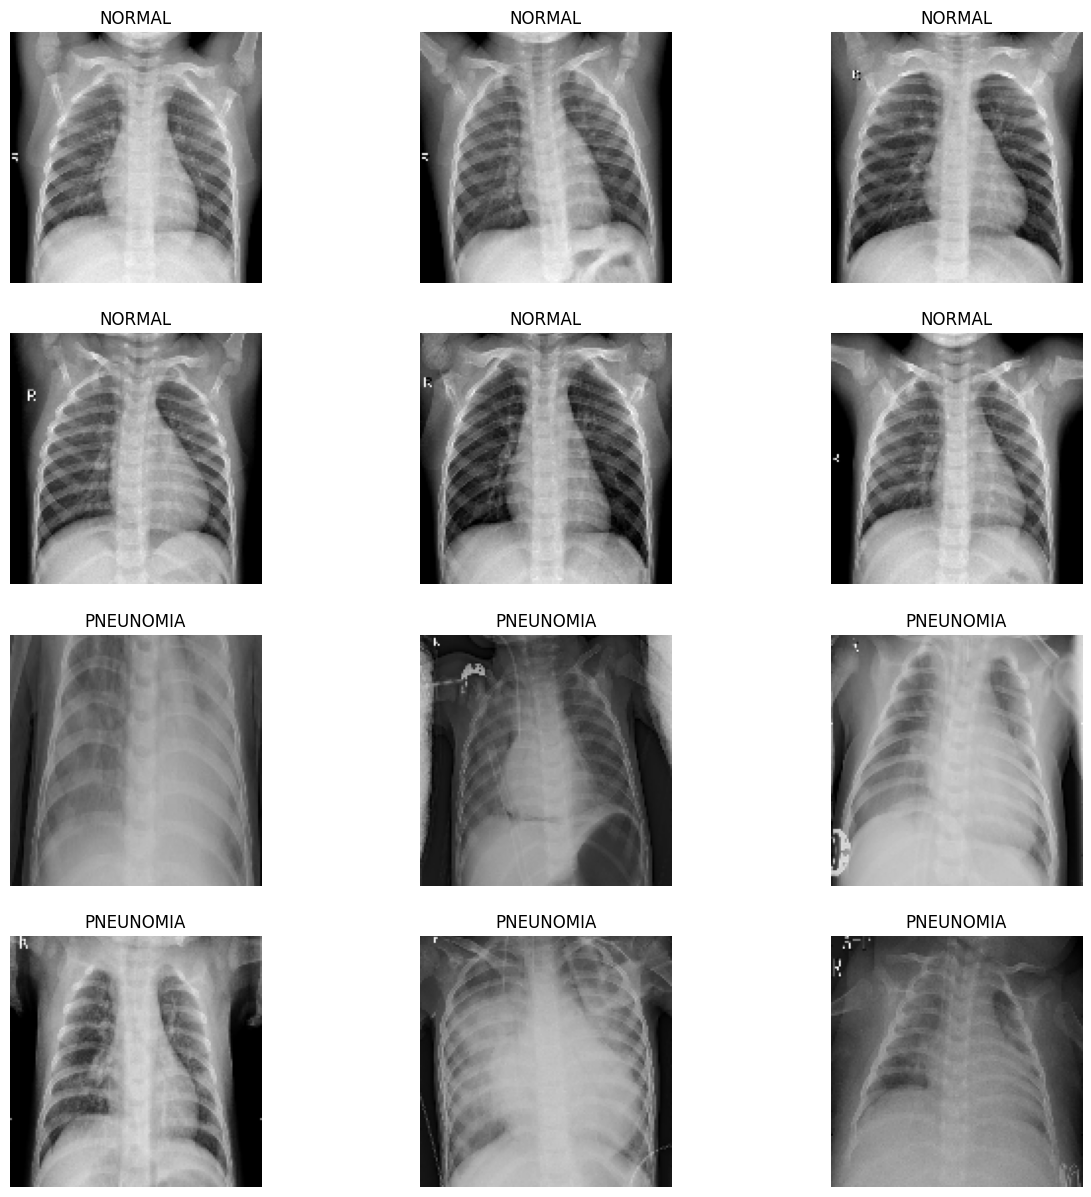

In [ ]:
## Train folder
fig=plt.figure(figsize=(15, 15))
columns = 3; rows = 4
for i in range(1, columns*rows +1):
    if i <=6:
        img = cv2.imread(glob.glob("/tmp/chest_xray/train/NORMAL/*.jpeg")[i])
    else:
        img = cv2.imread(glob.glob("/tmp/chest_xray/train/PNEUMONIA/*.jpeg")[i])
    img = cv2.resize(img, (128, 128))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(label="NORMAL" if i<=6 else "PNEUNOMIA")
    plt.axis(False)

In [ ]:
# Gaussian Blur
# In Gaussian Blur operation, the image is convolved with a Gaussian filter instead of the box filter. The Gaussian filter is a low-pass filter that removes the high-frequency components are reduced.

def subtract_gaussian_bg_image(im):
    k = np.max(im.shape)/10
    bg = cv2.GaussianBlur(im ,(0,0) ,k)
    return cv2.addWeighted (im, 4, bg, -4, 128)

In [ ]:
# Median
# The Median blur operation is similar to the other averaging methods. Here, the central element of the image is replaced by the median of all the pixels in the kernel area. This operation processes the edges while removing the noise.

def subtract_median_bg_image(im):
    k = np.max(im.shape)//20*2+1
    bg = cv2.medianBlur(im, k)
    return cv2.addWeighted (im, 4, bg, -4, 128)

In [ ]:
# Averaging
# During this operation, the image is convolved with a box filter (normalized). In this process, the central element of the image is replaced by the average of all the pixels in the kernel area.

def subtract_average_bg_image(im):
    bg = cv2.blur(im, (10,10))
    return bg

In [ ]:
img_arr=[]
for i in range(0, 4):
    img = cv2.imread(glob.glob("/tmp/chest_xray/train/NORMAL/*.jpeg")[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img1 = subtract_gaussian_bg_image(img)
    img_arr.append(img1)
    img2 = subtract_median_bg_image(img)
    img_arr.append(img2)
    img3 = subtract_average_bg_image(img)
    img_arr.append(img3)

In [ ]:
### Geometric transformations

def affine_tf(img):
    rows, cols, ch = img.shape
    pts1 = np.float32([[50, 50],
                       [200, 50], 
                       [50, 200]])
    pts2 = np.float32([[10, 100],
                       [200, 50], 
                       [100, 250]]) 
    M = cv2.getAffineTransform(pts1, pts2)
    dst = cv2.warpAffine(img, M, (cols, rows))
    return dst

def rotation(img): 
    dst = cv2.rotate(img, cv2.cv2.ROTATE_90_CLOCKWISE)
    return dst

def resize(img):
    dst = cv2.resize(img, (780, 540),interpolation = cv2.INTER_NEAREST)
    return dst

def colormaps(img):
    dst = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    return dst

In [ ]:
# ## MODEL TRAINING

In [ ]:
## Images are of different sizes fixing the size to 180
imageSize = 180
batchSize = 32
NUM_CLASSES = 2 ## since there are 2 distinct classes

In [ ]:
# Define Training and Validation Data Generator with Augmentations
gen = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=0.4,
    zoom_range=0.4
)

In [ ]:
# Flow the data into the Data Generator
Train_gen = gen.flow_from_directory(
    "/tmp/chest_xray/train",
    target_size=(180, 180),
    batch_size=16
)
Test_gen = gen.flow_from_directory(
    "/tmp/chest_xray/test",
    target_size=(180, 180),
    batch_size=8
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
Train_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
model_densetnet = tf.keras.applications.DenseNet201(input_shape=(180,180,3),include_top=False,weights='imagenet',pooling='avg')
model_densetnet.trainable = False

74836368/74836368 [==============================] - 4s 0us/step


In [ ]:
input = model_densetnet.input
# Rebuild top
x = tf.keras.layers.Dense(128,activation="relu")(model_densetnet.output)
x = tf.keras.layers.BatchNormalization()(x)
top_dropout_rate = 0.2
x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
output = tf.keras.layers.Dense(2, activation='softmax')(x)
model = tf.keras.Model(inputs=input, outputs=output)

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 186, 186, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 90, 90, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1/conv[0][0]']         

In [ ]:
### we will train for 50 epochs only
hist = model.fit(
    Train_gen,
    epochs=30,
    validation_data=Test_gen
)

Epoch 1/30
326/326 [==============================] - 154s 398ms/step - loss: 0.3010 - accuracy: 0.8869 - val_loss: 0.4253 - val_accuracy: 0.8446
Epoch 2/30
326/326 [==============================] - 123s 376ms/step - loss: 0.1902 - accuracy: 0.9239 - val_loss: 0.6689 - val_accuracy: 0.7772
Epoch 3/30
326/326 [==============================] - 121s 370ms/step - loss: 0.1773 - accuracy: 0.9293 - val_loss: 0.4096 - val_accuracy: 0.8397
Epoch 4/30
326/326 [==============================] - 121s 370ms/step - loss: 0.1738 - accuracy: 0.9342 - val_loss: 0.4196 - val_accuracy: 0.8446
Epoch 5/30
326/326 [==============================] - 119s 365ms/step - loss: 0.1637 - accuracy: 0.9360 - val_loss: 0.2587 - val_accuracy: 0.9054
Epoch 6/30
326/326 [==============================] - 130s 399ms/step - loss: 0.1755 - accuracy: 0.9283 - val_loss: 0.5245 - val_accuracy: 0.8205
Epoch 7/30
326/326 [==============================] - 120s 368ms/step - loss: 0.1644 - accuracy: 0.9362 - val_loss: 0.4608 -

In [ ]:
model.save("DenseNet201.h5")

In [ ]:
# Evaluate the model
scores = model.evaluate_generator(Test_gen)
print("Loss of the model: %.2f"%(scores[0]))
print("Test Accuracy: %.2f%%"%(scores[1] * 100))

<ipython-input-31-f033a7639512>:2: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Loss of the model: 0.37
Test Accuracy: 85.74%


In [ ]:
Val_gen = gen.flow_from_directory(
    "/tmp/chest_xray/val",
    target_size=(180, 180),
    batch_size=1
)

Found 16 images belonging to 2 classes.


In [ ]:
# Evaluate the model
scores = model.evaluate_generator(Val_gen)
print("Loss of the model: %.2f"%(scores[0]))
print("Val Accuracy: %.2f%%"%(scores[1] * 100))

<ipython-input-33-f5977d72d7a1>:2: UserWarning:

`Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.



Loss of the model: 0.50
Val Accuracy: 68.75%


In [ ]:
STEP_SIZE_TEST=Val_gen.n
Val_gen.reset()
Val_pred=model.predict_generator(Val_gen,steps=STEP_SIZE_TEST,verbose=1)

<ipython-input-34-5bf926cf21d4>:3: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



16/16 [==============================] - 5s 29ms/step


In [ ]:
## get prediction for Val data set
prediction=[]
for i in range(Val_pred.shape[0]):
    prediction.append("Normal" if Val_pred[i][0]>0.5 else "Pneumonia")

In [ ]:
val_data={}
for i in glob.glob('/tmp/chest_xray/val/NORMAL/*.jpeg'):
    val_data[i[-25:]]="NORMAL"
for i in glob.glob('/tmp/chest_xray/val/PNEUMONIA/*.jpeg'):
    val_data[i[-29:]]="PNEUMONIA"

In [ ]:
val_df=pd.DataFrame(columns=['image','label','prediction'])
image=[]
label=[]
for k,v in val_data.items():
    image.append(k)
    label.append(v)
    
val_df['image']=image
val_df['label']=label
val_df['prediction']=prediction

In [ ]:
val_df

,image,label,prediction
0,NORMAL2-IM-1438-0001.jpeg,NORMAL,Pneumonia
1,NORMAL2-IM-1431-0001.jpeg,NORMAL,Pneumonia
2,NORMAL2-IM-1427-0001.jpeg,NORMAL,Pneumonia
3,NORMAL2-IM-1442-0001.jpeg,NORMAL,Pneumonia
4,NORMAL2-IM-1440-0001.jpeg,NORMAL,Normal
5,NORMAL2-IM-1436-0001.jpeg,NORMAL,Pneumonia
6,NORMAL2-IM-1430-0001.jpeg,NORMAL,Pneumonia
7,NORMAL2-IM-1437-0001.jpeg,NORMAL,Normal
8,person1947_bacteria_4876.jpeg,PNEUMONIA,Pneumonia
9,person1946_bacteria_4874.jpeg,PNEUMONIA,Normal
